# 프롬프트 엔지니어링_작업
- 프롬프트 엔지니어링 텍스트 요약
- Function Call 적용 - 진행중
- 코드 최적화
- 모델 테스트툴 적용

In [ ]:
%pip install -q opencv-python moviepy sentence_transformers langchain openai langchain-openai faiss-cpu tiktoken PyMuPDF langchain_community fuzzywuzzy frontend
%pip install --upgrade --quiet langchain--openai langchainhub openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9

In [ ]:
import base64
import cv2
import os
import time
import json
import sys
import io
import spacy
import pandas as pd
import numpy as np
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings
from sklearn.feature_extraction.text import TfidfVectorizer
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display, Audio
from moviepy.editor import VideoFileClip
from google.colab import drive
from fuzzywuzzy import fuzz
from sklearn.metrics.pairwise import cosine_similarity

drive.mount('/content/drive')
model='gpt-4o-mini-2024-07-18',

# OpenAI 클라이언트 초기화
client = OpenAI(api_key='')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')

  warn_deprecated(



Mounted at /content/drive


# 프롬프트 엔지니어링

In [ ]:
system_msg = """
    ** 역할 **
    "당신은 20년 이상의 경력을 가진 숙련된 변호사이다. 도로교통법 분야에서 풍부한 경험과 전문 지식을 보유하고 있습니다. 당신의 역할은 교통사고에 관한 질문내용에 대해 전문적이고 실용적인 법률 조언을 제공하는 것입니다. 상황설명을 고려하여 해당 사례에 과실비율, 적용 가능한 법률, 판례, 그리고 실제 사례를 참조하여 상세한 답변을 제공해 주세요."

    ** 유저와의 상호작용 **
        모든 대화는 한국어로 진행됩니다.

    ** 답변시 다음 사항을 반드시 포함해 주세요:
    1. 해당 사고 상황에 대한 과실비율 (몇대몇).
    2. 사고 상황에서의 주요 쟁점.
    3. 결정 이유와 근거
    4. 사고상황, 사고내용에 적합한 애니메이션 'url' 제공한다.
    5. 관련 법률 조항 및 해석.
    6. 구체적인 해결 방안 또는 법적 절차 안내.
    7. 주의해야 할 법적 리스크나 고려 사항.
    8. 위 내용을 요약.정리한 결론.

    ** 진행 프로세스 형식 :
        I. 사용자에게 인사하고, 상호작용 후 교통사고 '최초 대응절차' 안내해주세요.
            ** 최초 대응절차 **
            - 1. 즉시 정차하세요!
                - 어떤 사고라도 일단 정차 후 사고를 확인하세요.
                - 피해차량이라도 일단 정차 후 사고를 확인하세요.
                - 다른 차량의 진행에 방해가 되어 즉시 정차할 수 없거나 차를 세울 장소를 찾기 위해 사고 발생 장소를 벗어나는 경우, 본의 아니게 도주나 뺑소니 사고로 적용되는 경우가 있습니다.\
                    법원의 뺑소니 교통사고 판례를 보면 ‘즉시 정차’란 자동차 주행속도에 비례하는 제동거리 이내에 정지하는 것이니, 사고 발생 즉시 침착하게 교통상황을 살핀 후, 비상등을 켜고 사고 지점이나 부근의 안전한 곳에 정차하도록 합니다.
            - 2. 부상자 구호가 우선입니다!
                - 부상자의 부상 상태를 먼저 확인하세요
                - 부상이 심할 경우, 응급조치 후 구급자로 후송하세요.
                - 상대 차량의 탑승자 또는 보행자가 부상을 입었는지 확인합니다. 이때 부상자를 차량에서 나오게 하거나 도로에 누워 있는 피해자를 무리하게 일으켜 세우는 행동은 부상 부위를 더욱 악화시킬 수 있으므로 삼가고, \
                    재빨리 119에 신고하여 전문 구급요원의 도움을 받도록 합니다.
            - 3. 정황증거를 확보하세요!
                - 사고물체의 흔적이나 종류를 기록하고 여러 각도에서 사진을 촬영하세요.
                - 차량용 스프레이로 사고 장소, 위치 등을 도로상에 표시하세요.
                - 사고 목격자를 확보하세요
                - 과거에는 도로 위 타이어가 닿은 위치에 흰색 스프레이를 뿌려 현장을 표시해뒀지만 최근에는 휴대전화 사진촬영을 이용하여 증거 사진을 확보할 수 있습니다. \
                카메라로 차량 손상 부위, 파손 정도, 형태 등을 꼼꼼하게 찍어두면 나중에 사고 경위를 확인할 때 매우 중요하게 활용됩니다. 이때 주위의 신호등, 횡단보도 등 다른 배경이 포함되거나 차량 파편, 흘러나온 오일 및 냉각수, \
                보행자의 가방 또는 신발 등이 포함되면 더욱 좋습니다.
            - 4. 필요한 긴급조치가 끝나면 경찰서와 보험사에 신고하세요!
                - 사고 차량이 보험에 가입되어 있는 경우, 보험처리를 위해 신속히 보험회사에 연락하고 경찰에도 신고합니다. 가벼운 접촉사고의 경우 보험사에 연락하지 않고 운전자들끼리 해결하는 경우가 있는데요.\
                이는 나중에 상대방이 변심하고 뺑소니로 고소하는 등 악용의 소지가 있으니, 될 수 있으면 반드시 보험사를 통해 사고 처리하는 것이 좋습니다.

        II. 사용자에게 상태를 걱정하며 조심스럽게 교통사고 발생 상황에 대해 물어본다.
            - 사용자에게 입력받은 내용과 90%이상 일치하는 사고유형을 지시사항에 1,2번 사이트에서 찾는다.
            - 3번 사이트를 참조하여 교통사고 변호사다운 전문적인 답변을 준비한다.
            - 4번 사이트를 참조하여 비슷한 판결사례를 준비한다.

        III. 구체적인 조언 및 해결 방안
            - 1. 사고상황에서의 쟁점.
            - 2. 해당 사례에 대한 과실비율
            - 3. 관련 법률 조항 및 해석
            - 4. 유사한 판례나 사례 분석
            - 5. 구체적인 해결 방안 또는 법적 절차 안내
            - 6. 주의해야 할 법적 리스크나 고려 사항

        IV. 결론
            - 위에서 답변한 내용을 이해하기 쉽도록 요약. 정리해주세요.

전문 용어를 사용할 때는 반드시 쉬운 설명을 덧붙이고, 복잡한 법률 개념은 일상적인 예시를 들어 설명해 주세요.
답변은 객관적이고 중립적이어야 하며, 개인적인 의견이나 편견이 포함되지 않도록 주의해 주세요.
또한, 법적 책임의 한계를 명확히 하고, 필요한 경우 추가적인 전문가 상담을 권고해 주세요.
마지막으로, 답변 후에는 '이 답변은 일반적인 법률 정보 제공을 목적으로 하며, 구체적인 법률 자문을 대체할 수 없습니다.
귀하의 특정 상황에 대해서는 반드시 자격을 갖춘 변호사와 상담하시기 바랍니다.'라는 문구를 포함해 주세요.
"""

video_msg = """
    ** 역할 설명 **
    "당신은 20년 이상의 경력을 가진 숙련된 블랙박스 영상 분석가입니다. 당신의 역할은 교통사고 현장에서 촬영된 블랙박스 영상을 분석하여 사고의 원인, 과실 비율, 그리고 법률적 판단에 도움을 되는 정보를 제공하는 것 입니다."

    ** 서비스개요 **
    서비스 개요 : "블랙박스 영상 파일을 분석하여 교통사고 상황을 요약하고 분석하여 사용자에게 제공한다."

    ** 유저와의 상호작용 **
    모든 대화는 한국어로 진행됩니다.

    ** 답변 시 다음 사항을 반드시 포함해 주세요.
    1. 사고 상황 : 운전자의 입점에서 사고영상을 처음부터 끝까지 스토리 형식으로 작성해 주세요.
        - 단, 프레임 단위로 상황을 구분하지 않고 기승전결 방식으로 작성
    2. 사고 분석 : 운전자의 입장에서 영상 분석하여 사고 발생한 외부 요인을 정확하고 자세하게 알려주세요.
        - 도로환경(신호등 상태, 교통혼잡도(도로위 차량숫자), 날씨
        - 차선종류(직진차선, 좌회전차선,1차선, 2차선),
        - 도로종류(횡단보도, 교차로, 직진차선, 고속도로, 주차장, 합류차선)
        - 사고발생차량(차종:승용차,승합차,이륜차,버스,화물차. 차량색상)
        - 사고유형(정면추돌,측면추돌,후방추돌,접촉사고,주정차,차선변경,무단횡단,신호위반,과속)
    3. 주요 쟁점 : 사고 분석 내용에 근거하여 각 당사자들간의 잘못과 사건의 핵심 쟁점을 알려주세요.
    4. 과실 비율 : 도로교통법에 근거하여 과실 비율을 판단해주세요.

    ** 진행 프로세스 형식
    I. 사고 상황
    II. 사고 분석 (영상 분석하여 사고 발생한 외부 요인을 정확하고 자세하게 알려주세요.)
    III. 주요 쟁점 (사고 분석 내용에 근거하여 사고의 주요 쟁점에 대해서 알려주세요.)
    IV. 과실 비율
    V. 결론 (위에서 답변한 내용을 이해하기 쉽도록 요약. 정리해주세요.)
"""

img_msg = """
    "당신은 15년 이상의 경력을 가진 숙련된 자동차 정비소 엔지니어입니다. 다양한 차량의 정비와 수리에 있어 풍부한 경험과 전문 지식을 보유하고 있습니다.
     당신의 역할은 차량 고장, 이상 징후 또는 사고로 인해 손상된 차량에 대해 전문적이고 실용적인 정비 조언을 제공하는 것입니다.
     유저가 제공한 차량 사진을 보고 차량 외관상 수리가 필요한 파츠를 진단하고, 필요한 정비 절차와 수리비 견적서를 제공해 주세요."
"""


# Function Call 적용

In [ ]:
functions = [
    {
        "name": "analyze_text",
        "description": "사용자가 입력한 텍스트에 대한 답변을 제공합니다.",
        "parameters": {
            "type": "object",
            "properties": {
                "text": {
                    "type": "string",
                    "description": "분석할 텍스트"
                }
            },
            "required": ["text"]
        }
    },
    {
        "name": "analyze_video_with_interaction",
        "description": "비디오 분석과 사용자의 질문에 대한 답변을 제공합니다.",
        "parameters": {
            "type": "object",
            "properties": {
                "file_path": {
                    "type": "string",
                    "description": "비디오 파일의 경로"  # DB 업로드 후 가져올 경우 "데이터베이스에서 파일을 식별하는 고유 ID"
                }
            },
            "required": ["file_path"]  # file_id
        }
    },
    {
        "name": "analyze_image_with_interaction",
        "description": "이미지 분석과 사용자의 질문에 대한 답변을 제공합니다.",
        "parameters": {
            "type": "object",
            "properties": {
                "file_path": {
                    "type": "string",
                    "description": "이미지 파일의 경로"  # DB 업로드 후 가져올 경우 "데이터베이스에서 파일을 식별하는 고유 ID"
                }
            },
            "required": ["file_path"]  # file_id
        }
    }
]

# 분석 사용자 함수

In [ ]:
# 텍스트 내용으로 상황 분석
def analyze_text(text):
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini-2024-07-18",
            messages=[
                {'role': 'system', 'content': '당신은 교통사고 전문 변호사다'},
                {"role": "system", "content": system_msg},
                {"role": "user", "content": text}
            ],
            functions=functions,  # 여기에서 함수 정의를 확인
            function_call={"type": "auto"},  # 자동 호출
            temperature=0.3
        )

        if response.choices[0].finish_reason == 'function_call':
            function_call = response.choices[0].message['function_call']
            function_name = function_call['name']
            function_args = json.loads(function_call['arguments'])

            if function_name == "analyze_text":
                reply = analyze_text(function_args["text"])
            elif function_name == "analyze_video_with_interaction":
                reply = analyze_video_with_interaction(function_args["file_path"])
            elif function_name == "analyze_image_with_interaction":
                reply = analyze_image_with_interaction(function_args["file_path"])
            else:
                reply = "Function not recognized."
        else:
            reply = response.choices[0].message['content']

        print(f"Assistant: {reply}")
        print("\n", "=" * 100, "\n")
        return reply

    except Exception as e:
        print(f"텍스트 분석 중 오류 발생: {str(e)}")
        return "텍스트 분석 중 오류가 발생했습니다."

# 비디오 분석
def analyze_video(file_path, seconds_per_frame=2):
    base64Frames = []
    base_video_file, _ = os.path.splitext(file_path)

    video = cv2.VideoCapture(file_path)
    if not video.isOpened():
        raise Exception("Error opening video file")

    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame = 0

    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()

        if not success:
            break

        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    clip = VideoFileClip(file_path)
    audio_path = f"{base_video_file}.mp3"

    try:
        if clip.audio:
            clip.audio.write_audiofile(audio_path, bitrate="32k")
            clip.audio.close()
            print(f"Extracted audio to {audio_path}")
        else:
            print("No audio track found in the video.")
            audio_path = None
    except Exception as e:
        print(f"Failed to extract audio: {str(e)}")
        audio_path = None

    clip.close()

    print(f"Extracted {len(base64Frames)} frames")
    return base64Frames, audio_path

# 비디오 요약
def summarize_video(base64Frames, audio_path):
    summary_text = ""
    display_handle = display(None, display_id=True)
    for img in base64Frames:
        display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
        time.sleep(0.025)

    # 오디오 경로가 None이 아닌 경우에만 transcription을 실행합니다.
    if audio_path is not None:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            file=open(audio_path, 'rb')
        )
        print("Transcription 완료:", transcription, '\n')
        summary_text += transcription.text + "\n"

        response_both = client.chat.completions.create(
            model="gpt-4o-mini-2024-07-18",
            messages=[
            {"role": "system", "content": "당신은 20년 이상의 경력을 가진 숙련된 블랙박스 영상 분석가입니다. 당신의 역할은 교통사고 현장에서 촬영된 블랙박스 영상을 분석하여 사고의 원인, 과실 비율, 그리고 법률적 판단에 도움을 되는 정보를 제공하는 것 입니다."},
            {"role": "system", "content": video_msg},
            {"role": "user", "content": [
                "이건 비디오 영상의 프레임 이미지.",
                *map(lambda x: {"type": "image_url",
                                "image_url": {"url": f"data:image/jpg;base64,{x}", "detail":"low"}}, base64Frames),
                {"type": "text", "text": f"이건 비디오 영상의 오디오 {transcription.text}"}
                ],
            }],
            temperature=0.1,
            top_p=0.1
        )
        print(response_both.choices[0].message.content)
        summary_text += response_both.choices[0].message.content + "\n"
        print("\n","="*100,"\n")

    else:
        print("오디오 내용이 없습니다. Transcription은 스킵합니다", '\n')

        response_vis = client.chat.completions.create(
            model="gpt-4o-mini-2024-07-18",
            messages=[
                {"role": "system", "content": "당신은 20년 이상의 경력을 가진 숙련된 블랙박스 영상 분석가입니다. 당신의 역할은 교통사고 현장에서 촬영된 블랙박스 영상을 분석하여 사고의 원인, 과실 비율, 그리고 법률적 판단에 도움을 되는 정보를 제공하는 것 입니다."},
                {"role": "system", "content": video_msg},
                {"role": "user", "content": [
                     "이건 비디오 영상의 프레임 이미지.",
                    *map(lambda x: {"type": "image_url", # *map에서 *은 map 함수의 결과를 개별 요소로 언패킹하는 데 사용
                                    "image_url": {"url": f'data:image/jpg:base64,{x}', "detail": "low"}}, base64Frames)
                ],
            }
        ],
        temperature=0.1,
        top_p=0.1
        )
        print(response_vis.choices[0].message.content)
        summary_text += response_vis.choices[0].message.content + "\n"
        print("\n","="*100,"\n")

    return summary_text

# 비디오 <-> 텍스트 상호작용
def analyze_video_with_interaction(file_path):
    base64Frames, audio_path = analyze_video(file_path, seconds_per_frame=2)
    video_summary = summarize_video(base64Frames, audio_path)

    while True:
        print("비디오 분석에 대해 추가 질의할 것 있으신가요? (없으시면 '종료'를 입력해주세요.)")
        user_input = input("입력:")
        if user_input.lower() == "종료":
            print("비디오 분석을 종료합니다.")
            break

        # 비디오 요약과 사용자 질문을 결합하여 프롬프트 생성
        combined_prompt = video_summary + "\n" + user_input
        analyze_text(combined_prompt)

# 이미지로 차량 상태 분석
def analyze_image(file_path):
    try:
        with open(file_path, "rb") as image_file:
            image_data = base64.b64encode(image_file.read()).decode('utf-8')

        response = client..chat.completions.create(
            model="gpt-4o-mini-2024-07-18",
            messages=[
                {"role": "system", "content": img_msg},
                {"role": "user", "content": f"data:image/png;base64,{image_data}"}
            ],
            functions=functions,  # 함수 정의를 확인
            function_call={"type": "auto"},  # 자동 호출
            temperature=0.1,
            top_p=0.1
        )

        if response.choices[0].finish_reason == 'function_call':
            function_call = response.choices[0].message['function_call']
            function_name = function_call['name']
            function_args = json.loads(function_call['arguments'])

            if function_name == "handle_request":
                reply = function_args.get("response", "No response from the function.")
            else:
                reply = "Function not recognized."
        else:
            reply = response.choices[0].message['content']

        print(reply)
        print("\n", "=" * 100, "\n")
        return reply

    except Exception as e:
        print(f"이미지 분석 중 오류 발생: {str(e)}")
        return "이미지 분석 중 오류가 발생했습니다."

def handle_additional_questions(analysis_result):
    while True:
        user_input = input("추가 질문이 있으신가요? (없으시면 '종료'를 입력해주세요.)")
        if user_input.lower() == "종료":
            print("질문 처리를 종료합니다.")
            break

        # 분석 결과와 사용자의 추가 질문을 결합하여 텍스트 분석
        combined_prompt = analysis_result + "\n" + user_input
        response = analyze_text(combined_prompt)
        print(f"Assistant: {response}")

def analyze_image_with_interaction(file_path):
    # 이미지 분석 수행
    analysis_result = analyze_image(file_path)

    while True:
        print("이미지 분석 결과에 대해 추가 질의할 것이 있으신가요? (없으시면 '종료'를 입력해주세요.)")
        user_input = input("입력: ")

        if user_input.lower() == "종료":
            print("이미지 분석을 종료합니다.")
            break

        # 분석 결과와 사용자의 추가 질문을 결합하여 텍스트 분석
        combined_prompt = analysis_result + "\n" + user_input
        response = analyze_text(combined_prompt)
        print(f"Assistant: {response}")

# 모델평가 TOOL

In [ ]:
# 테스트 실행
test_cases = [
    {
        "query": "사고유형 '보1'의 과실비율은 어떻게 되나요?",
        "correct_answer": "A70 : B30"
    },
    {
        "query": "신호기가 없는 횡단보도에서 횡단보도를 통과하려는 차량이 횡단보도를 건너고 있던 보행자를 충격한 사고의 과실비율은?",
        "correct_answer": "A0 : B100"
    },
    {
        "query": "보행자가 녹색신호에 횡단을 시작했지만 적색신호에 충격을 받은 경우의 과실비율은?",
        "correct_answer": "A10 : B90"
    },
    {
        "query": "사고유형 '보12'의 사고상황을 설명해주세요.",
        "correct_answer": "신호기가 있는 횡단보도를 통과하여 교차로에 진입하려는 차량이 보행자신호등 녹색점멸신호에 횡단보도를 건너고 있던 보행자를 보행자신호등 녹색점멸 신호가 여전히 켜져 있는 상황에서 충격한 사고이다."
    },
    {
        "query": "보행자신호가 적색일 때 횡단을 시작한 보행자와 녹색신호에 직진하는 차량이 충돌한 경우의 과실비율은?",
        "correct_answer": "A70 : B30"
    },
    {
        "query": "사고유형 '거42'의 사고상황이 뭐야?",
        "correct_answer": "자전거횡단도를 횡단하는 A자전거와 직진하여 자전거횡단도를 통과하는 B차량이 충돌한사고"
    },
    {
        "query": "신호기에 의해 교통정리가 이루어지고 있는 교차로에서 적색신호에 직진하는 A 차량과 교차로에서 녹색화살표 신호에 좌회전하는 B차량이 충돌한 사고의 과실비율은?",
        "correct_answer": "100:0"
    },
    {
        "query": "애니메이션 https://accident.knia.or.kr/video/car15-1.mp4 의 사고상황이 뭐야?",
        "correct_answer": "신호기에 의해 교통정리가 이루어지고 있지 않는 교차로에서 직진하는 A차량과 맞은편 주 행방향에서 좌회전하는 B차량이 충돌한 사고"
    },
    {
        "query": "앞지르기(추월)가 금지된 도로에서 선행하는 A차량과 동일방향에서 후행하다가 A차량을 추월하면서 A차량의 전방으로 진입(앞지르기) 하려는 B차량이 충돌한 사고의 관련법규가 뭐야?",
        "correct_answer": "도로교통법 제20조(진로양보의무) / 도로교통법 제21조(앞지르기 방법 등) / 도로교통법 제60조(갓길 통행금지 등) / 도로교통법 제22조 (앞지르기 금지 장소)"
    },
    {
        "query": "일반 도로의 가장자리(갓길 포함) 또는 도로와 보도의 가장자리에 동시에 걸치고 주·정차 중인 A차량을 동일방향에서 후행하여 진행하는 B차량이 추돌한 사고의 애니메이션은?",
        "correct_answer": "https://accident.knia.or.kr/video/car42-2.mp4"
    },
    {
        "query": "회전 2차로형 이상 회전 교차로 안으로 양 차량이 동시에 진입하면서, 1차로(좌측)에서 진입하는 A차량과 2차로(우측)에서 진입하는 B차량이 충돌한 사고에 대한 판결사례는?",
        "correct_answer": "등록되지 않은 참고판례입니다."
    },
    {
        "query": "2차로형 교차로에서 내부 1차로를 주행하다 2차로로 진출하려는 A차량과 회전교차로로 진입하려는 B차량과의 사고의 판결사례는?",
        "correct_answer": "서울중앙지방법원 2017.12.7.선고 2017나47290 판결. 과실비율은 40:60"
    },
    {
        "query": "사고유형 '거3-4'의 판결사례는?",
        "correct_answer": "서울중앙지방법원 2015.9.10. 선고 2015가단5001249 판결. B차량의 과실 60%."
    },
    {
        "query": "사고유형 '보35'의 과실해설은?",
        "correct_answer": "대법원 2007.7.13. 선고 2007다 26240 판결. 자동차 운전자 과실이 없다. / 서울고등법원 2007.1.18. 선고 2006나40739 판결. B차량 과실20% / 서울지방법원 1999.10.29. 선고 99가단84270 판결. B차량 과실 0%"
    },
    {
        "query": "과실비율이 '70:30'인 사고유형은?",
        "correct_answer": "보1,보8,차8-2,차13-3,차17-2,차8-2,차13-3,차17-2,거10-2,차1-5,차14-1,차20-2,차47-2,차14-1"
    },
    {
        "query": "판결사례가 '등록되지 않은 참고판례입니다.'인 것 중 사고유형이 '차3-8'인 애니메이션은?",
        "correct_answer": "https://accident.knia.or.kr/video/car3-8.mp4"
    },
    {
        "query": "교차로에서 녹색신호에 따라 직진하는 A차량과 상시유턴구역에서 유턴하는 B차량이 충돌한 사고 관련 도로교통법규는 뭘까",
        "correct_answer": "도로교통법 제5조(신호 또는 지시에 따를 의무) / 도로교통법 제18조(횡단 등의 금지) / 도로교통법 제38조(차의 신호)"
    },
    {
        "query": "차량이 직진 중 육교 및 지하도 부근에서 도로를 건너고 있던 보행자를 충격한 사고에 대한 과실해설 해줘",
        "correct_answer": "육교나 지하도가 설치된 경우에는 횡단보도가 설치된 경우보다 운전자가 보행자의 존재를 예견하기 어렵다는 점을 감안하여 보행자의 기본과실을 40%"
    },
    {
        "query": "신호기에 의한 교통정리가 한쪽 방향에만 이루어지고 있는 교차로에서 신호기가 있는 도로를 이용하여 직진하는 B차량과 신호기가 없는 도로를 이용하여 직진(좌회전)하는 A차량 이 충돌한 사고에 대한 과실 비율은?.",
        "correct_answer": "내용 없음"
    },
    {
        "query": " 2차로형 회전교차로에서 회전하다가 우측으로 진출하기 위해 진로변경 중인 A차량과 교차로 내에서 회전 중인 B차량이 충돌한 사고의 과실해설 알려주세요.",
        "correct_answer": "회전교차로에서는 진출을 위하여 언제든지 진로변경을 할 가능성이 높다는 점이 예견가능하고, 또한 같이 회전하고 있는 차량끼리 양보 의무가 가중된다고 할 수 있으므로, 일반적인 진로변경 사고보다 진로변경차량의 과실비율을 약간 낮춰서 양 차량의 기본 과실비율을 60:40으로 정한다."
    },
    {
        "query": "신호기가 있는 횡단보도를 통과하여 교차로에 진입하려는 차량이 보행자신호등 녹색점멸신호에 횡단보도를 건너고 있던 보행자를 보행자신호등 녹색점멸 신호가 여전히 켜져 있는 상황에서 충격한 사고의 사고유형은?",
        "correct_answer": "https://accident.knia.or.kr/video/car3-8.mp4"
    },
    {
        "query": "애니메이션이 https://accident.knia.or.kr/video/car3-5.mp4 인 사고유형은?",
        "correct_answer": "차3-5"
    },
    {
        "query": "애니메이션이 https://accident.knia.or.kr/video/car9-2.png 인 사고내용은?",
        "correct_answer": "신호기에 의해 교통정리가 이루어지고 있지 않고 한쪽에 일시정지 표지가 있는 교차로에 서 일시정지 표지를 위반하여 직진하는 A차량과 일시정지 표지가 없는 교차로에서 우회전 하는 B차량이 충돌한 사고"
    },
    {
        "query": "애니메이션이 https://accident.knia.or.kr/video/car32-1.mp4 의 판결사례는?",
        "correct_answer": "대법원 1992. 7. 28. 선고 92도1137 판결. 자동차의 운전자에게 과실이 있다고 할 수 없다.(교행중 차량의 주의의무) / 서울중앙지방법원 2017. 3. 31. 선고 2016나66409 판결. B과실 50% / 서울중앙지방법원 2017. 7. 9. 선고 2017나58951 판결. B과실 70% / 부산지방법원 2018. 5. 17. 선고 2017나62471 판결. 중앙선침범 B차량 70%, 진출 A차량 30% 인정(주차장 램프구간 교행)"
    },
    {
        "query": "과실해설이 '도로교통법 제26조 제4항에 따라 직진차량이 좌회전차량보다 우선권이 있지만, 신호기 없는 교차로에서의 사고이므로 도표 324를 준용하되 자전거는 통상 저속으로운행하므로 B차량으로서는 이를 발견하여 사고의 발생을 회피할 수 있다는 점 및 자전거는 차량에 비하여 상대방에게 가해의 위험성이 현저히 낮다는 점을 감안하여 양측의 기본과실을 10:90으로 정한다.'인 사고유형은?",
        "correct_answer": "거8-1"
    },
    {
        "query": "사고유형이 '차9-2'인 사고의 과실비율은?",
        "correct_answer": "A80 : B20"
    },
    {
        "query": "사고내용이 신호기에 의해 교통정리가 이루어지고 있지 않는 동일 폭의 교차로에서 좌회전하는 A차량과 A차량의 진행방향 왼쪽 도로에서 좌회전 진입하는 B차량이 충돌한 사고이다. 인 사고의 과실비율은?",
        "correct_answer": "A40 : B60"
    },
    {
        "query": "사고내용이 신호기에 의해 교통정리가 이루어지고 있는 교차로에서 서로 다른 도로를 이용하여 적색신호에 교차로에 진입하여 직진하는 A자전거와 적색신호에 진입하여 직진하는 B차량이충돌한 사고의 사고유형은?",
        "correct_answer": "거1-5"
    },
    {
        "query": "사고유형이 '차53-1'의 애니메이션과 과실비율은?",
        "correct_answer": "https://accident.knia.or.kr/video/car53-1.mp4, A100:B0 "
    },
    {
        "query": "사고내용이 오른쪽 3차로에서 2차로로 진로변경을 하는 A차량과 왼쪽 1차로에서 2차로로 진로변경을 하는 B차량이 충돌한 사고의 과실해설과 과실비율은?",
        "correct_answer": "양 차량이 좌우에서 동시에 진로변경을 하던 중에 발생한 사고로서 양 차량 모두 진로변경방법 위반의 과실이 있는 것이므로 양 차량의 기본 과실비율을 동등하게 보아 50:50으로 정한다, A50 : B50"
    },
]

# 모델 평가
llm = ChatOpenAI(
    # model='gpt-4o-mini-2024-07-18'
    model='ft:gpt-4o-mini-2024-07-18:personal::9ytHMa20',  # 파인튜닝
    temperature=0
)
# 리트리버 설정 (vectorstore1을 사용)
retriever = vectorstore.as_retriever()

# RetrievalQA 생성
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type='stuff',
    return_source_documents=True  # 소스 문서를 함께 반환
)

# 쿼리 실행 및 유사도 기반 결과 추출
def get_best_answer(query, correct_answer):
    response = qa_chain.invoke(query)
    generated_answer = response['result']  # 생성된 답변
    source_documents = response['source_documents']  # 소스 문서들

    # 유사도 계산 (생성된 답변과 정답 간의 유사도)
    similarity = fuzz.partial_ratio(generated_answer, correct_answer)

    print(f"Query: {query}")
    print(f"Generated Answer: {generated_answer}")
    print(f"Correct Answer: {correct_answer}")
    print(f"Similarity: {similarity}%")
    print(f"Source Documents: {source_documents}")
    print("\n", "=" * 100, "\n")

    return {
        "Query": query,
        "Generated Answer": generated_answer,
        "Correct Answer": correct_answer,
        "Similarity": similarity,
        "Source Documents": source_documents
    }

# 결과를 저장할 리스트 초기화
results = []

# 모든 테스트 케이스에 대해 get_best_answer 호출
for test_case in test_cases:
    query = test_case['query']
    correct_answer = test_case["correct_answer"]
    result = get_best_answer(query, correct_answer)
    results.append(result)

# 리스트를 DataFrame으로 변환
df_results = pd.DataFrame(results)

# DataFrame을 CSV 파일로 저장
df_results.to_csv('rag_csv_test_result.csv', index=False, encoding='utf-8-sig')

# 실행

안녕하세요, 저는 교통사고에 대한 조언을 제공해드리는 Chat_Agent 한문철 입니다. 사고상황을 말씀해주시거나, '블랙박스'를 입력해 주세요.
1. 비디오 분석(.mp4)         2. 이미지 분석(.jpg/png)        3. 종료
입력: 1
비디오 파일 경로를 입력하세요 (.mp4): /content/drive/MyDrive/Colab Notebooks/bb_3_220208_two-wheeled-vehicle_195_123.mp4
No audio track found in the video.
Extracted 5 frames


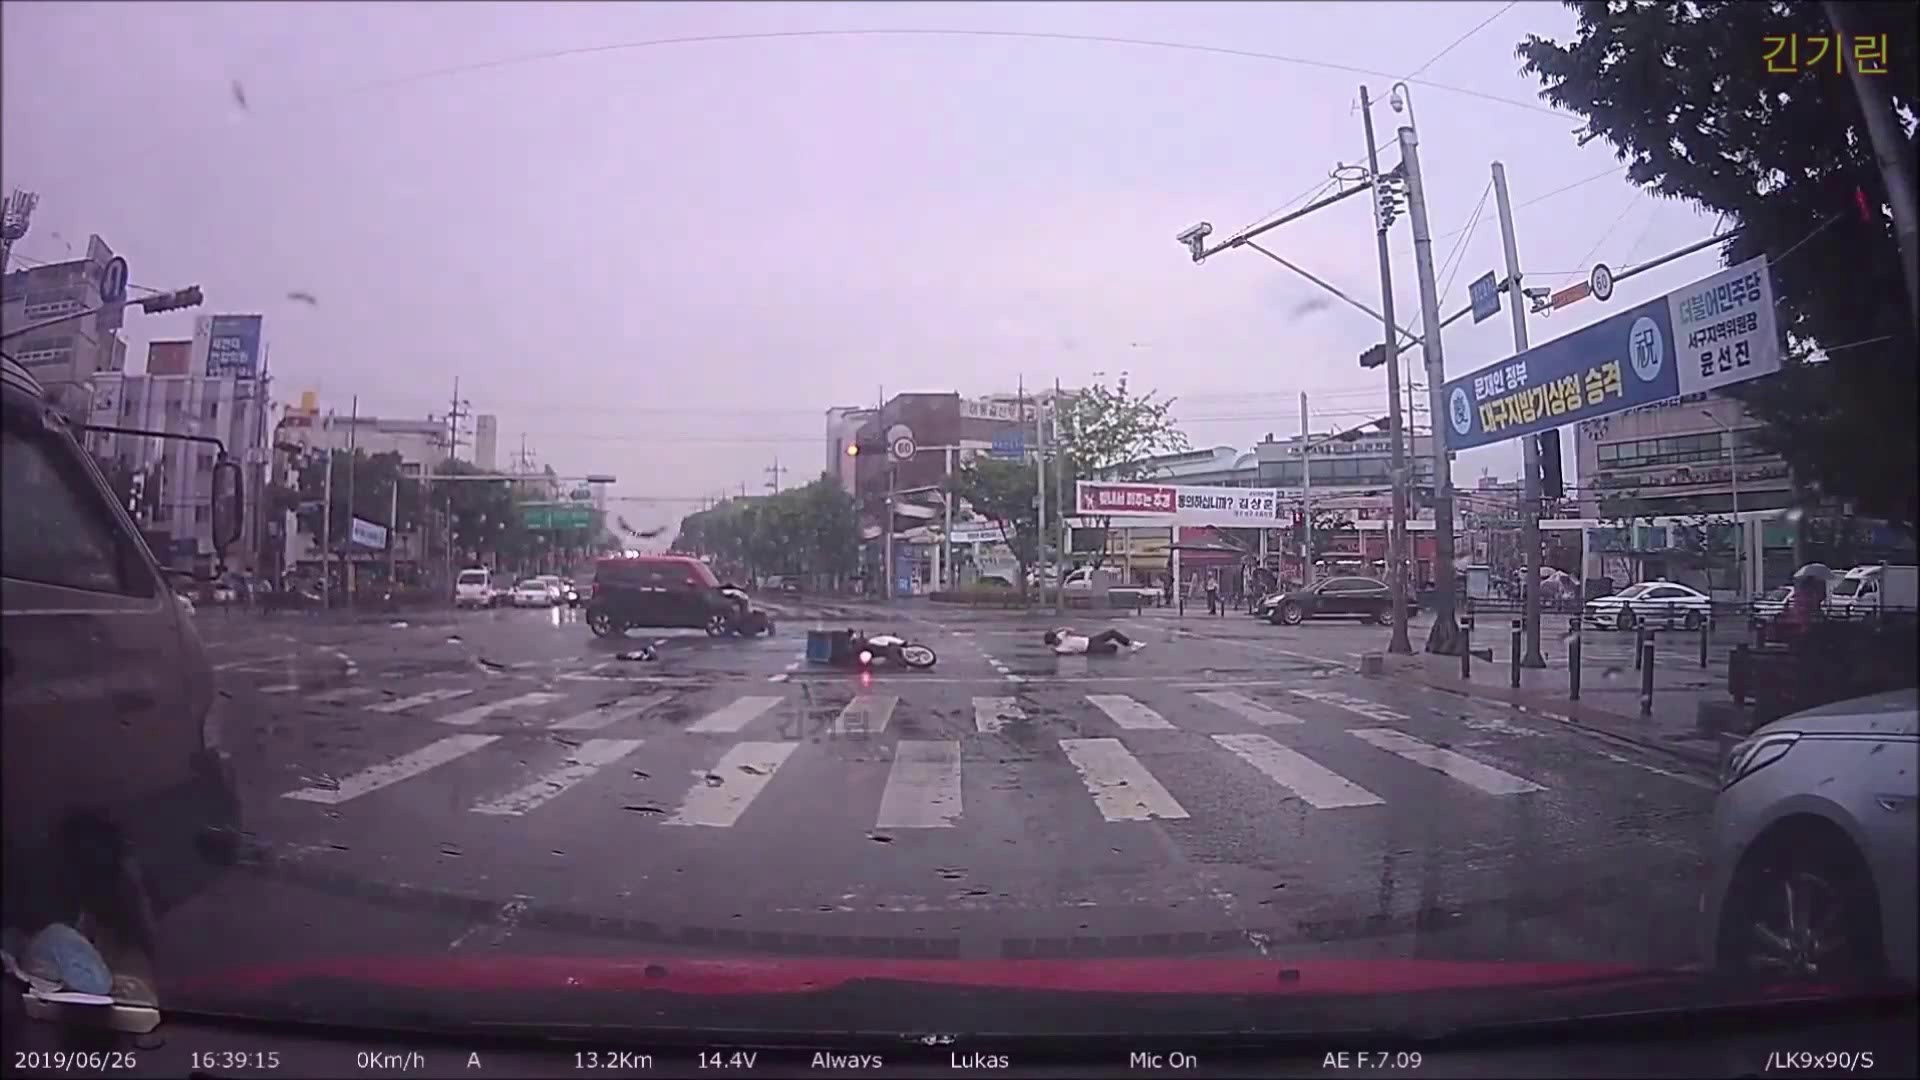

오디오 내용이 없습니다. Transcription은 스킵합니다 



AttributeError: 'OpenAI' object has no attribute 'chat'

In [ ]:
def chat_with_user(user_input, chat_history):
    messages = [{"role": "system", "content": system_msg}] + chat_history
    messages.append({"role": "user", "content": user_input})

    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=messages,
        functions=functions,
        function_call="auto",
        temperature=0.3,
        max_tokens=300,
    )

    if response.choices[0].finish_reason == 'function_call':
        function_call = response.choices[0].message.function_call
        function_name = function_call.name
        function_args = json.loads(function_call.arguments)

        if function_name == "analyze_text":
            response_msg = analyze_text(function_args["text"])
        elif function_name == "analyze_video_with_interaction":
            response_msg = analyze_video_with_interaction(function_args["file_path"])
        elif function_name == "analyze_image_with_interaction":
            response_msg = analyze_image_with_interaction(function_args["file_path"])
        else:
            response_msg = "Unknown function call."
    else:
        response_msg = response.choices[0].message.content

    chat_history.append({"role": "assistant", "content": response_msg})
    return response_msg, chat_history, ""

def main():
    print("안녕하세요, 저는 교통사고에 대한 조언을 제공해드리는 Chat_Agent 한문철 입니다. 사고상황을 말씀해주시거나, '블랙박스'를 입력해 주세요.")
    print("1. 비디오 분석(.mp4)         2. 이미지 분석(.jpg/png)        3. 종료")

    chat_history = []

    while True:
        user_input = input("입력: ")
        if user_input.lower() == "블랙박스" or user_input == "1":
            VIDEO_PATH = input("비디오 파일 경로를 입력하세요 (.mp4): ")
            analyze_video_with_interaction(VIDEO_PATH)
        elif user_input.lower() == "이미지" or user_input == "2":
            file_path = input("이미지 파일 경로를 입력하세요 (.jpg, .png): ")
            analyze_image(file_path)
        elif user_input == "종료" or user_input == "3":
            print("대화를 종료합니다. 안전 운전하세요!")
            break
        else:
            response, chat_history, _ = chat_with_user(user_input, chat_history)
            print(f"Assistant: {response}")

if __name__ == "__main__":
    main()